In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from scipy.optimize import root_scalar

In [2]:
data = pd.read_csv('mt_boson_list.csv', header=None) # Load the boson star projected mass profile
data.iloc[:, 1] = data.iloc[:, 1].astype(str).str.replace(r'\*\^', 'e', regex=True).astype(float)

plt.style.use(['science'])

## Normal PSPL lightcurve, no macro model

as a test

In [3]:
u_min = 1 #Default minimum impact parameter in units of r_E
t_E = 1 #Default Einstein crossing time

def impact_par(t, u_min=u_min, t_E=t_E): # Impact parameter as function of time
    return np.sqrt(u_min**2 + t**2/t_E**2)

def pspl_magnification(t): # Point source point lens magnification (analytic)
    u = impact_par(t)
    return (u**2 + 2) / (u*np.sqrt(u**2 + 4))


<function matplotlib.pyplot.show(close=None, block=None)>

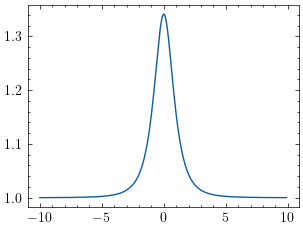

In [4]:
timestamps = np.arange(-10,10,0.1)

plt.plot(timestamps, pspl_magnification(timestamps))
plt.show


## PL microlens embedded in a macrolens
### Analytic solution

In [5]:
mu_r = 3 # macro model radial magnification
mu_t = 100 # Macro model tangential magnification

def tau_pl_pos(t,u_min=u_min,t_E=t_E): #position of positive image
    u = impact_par(t,u_min,t_E)
    return (mu_r/2)*u + np.sqrt((u**2)*(mu_r/2)**2 + mu_r)

def tau_pl_neg(t,u_min=u_min,t_E=t_E):  #position of negative image
    u = impact_par(t,u_min,t_E)
    return (mu_r/2)*u - np.sqrt((u**2)*(mu_r/2)**2 + mu_r)

def pl_embedded_magnification_inv(tau): # Inverse magnification in a macro model from an image at tau
    return (1/mu_r)*(1/mu_t) - ((1/mu_r)-(1/mu_t))*(1/tau**2) - (1/tau**4)

def pl_total_mag(t,u_min=u_min,t_E=t_E): # Total magnification from both images 
    return (1/np.abs(pl_embedded_magnification_inv(tau_pl_pos(t,u_min,t_E))) 
            + 1/np.abs(pl_embedded_magnification_inv(tau_pl_neg(t,u_min,t_E))))

Text(0.5, 1.0, 'Point Lens Lightcurve')

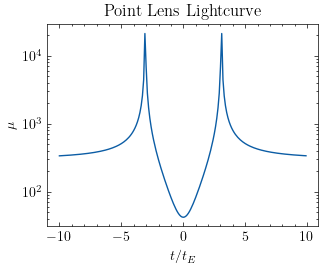

In [6]:
#plotting the lightcurve due to the point lens - log scale is easier to see the 'dip' magnification
plt.plot(timestamps, pl_total_mag(timestamps))
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.yscale('log')
plt.title(r'Point Lens Lightcurve')
# plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/pl_lightcurve.png', dpi=300, format='png')

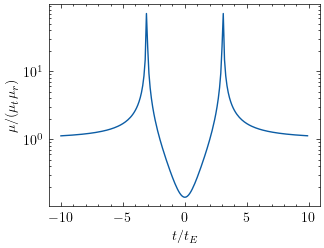

In [7]:
#plotting the relative magnification due to the point lens - the source is already
#magnified by the macro model, so we divide by the macro magnification

def relative_mag(t):
    return pl_total_mag(t)/(mu_t*mu_r)

plt.plot(timestamps,relative_mag(timestamps))
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu/(\mu_{t}\mu_{r})$')
plt.yscale('log')

### Numerical solution (test)
Testing solving the PL magnification numerically to compare against analytic solution and check BS mag has been solved correctly

In [8]:
def pl_lens_eqn(tau,t): # Point lens equation for image position(s) at time t
    return (tau / mu_r) - (1/tau) - impact_par(t) #image positions solve this equalling 0

all_solutions_pl = []

for t in timestamps:

    pl_tau_values_pos = np.linspace(0.001, 100, 10000)

    pl_lens_eqn_vals_pos = pl_lens_eqn(pl_tau_values_pos, t) # Evaluate the lens equation for positive image position(s)

    pl_roots_pos = []

    for i in range(len(pl_tau_values_pos) - 1):
        if pl_lens_eqn_vals_pos[i] * pl_lens_eqn_vals_pos[i+1] < 0:
            a, b = pl_tau_values_pos[i], pl_tau_values_pos[i+1]
            sol = root_scalar(pl_lens_eqn, args=(t,), bracket=[a, b], method='brentq')
            if sol.converged:
                pl_roots_pos.append(sol.root)

    pl_tau_values_neg = np.linspace(-100, -0.001, 10000)

    pl_lens_eqn_vals_neg = pl_lens_eqn(pl_tau_values_neg, t) # Evaluate the lens equation for negative image position(s)

    pl_roots_neg= []

    for i in range(len(pl_tau_values_neg) - 1): # Check for sign changes in the lens equation values to find the solutions
        if pl_lens_eqn_vals_neg[i] * pl_lens_eqn_vals_neg[i+1] < 0:
            a, b = pl_tau_values_neg[i], pl_tau_values_neg[i+1]
            sol = root_scalar(pl_lens_eqn, args=(t,), bracket=[a, b], method='brentq')
            if sol.converged:
                pl_roots_neg.append(sol.root)

    all_solutions_pl.append((pl_roots_pos, pl_roots_neg)) 

all_solutions_pl

[([30.24880433717485], [-0.09917747381218357]),
 ([29.951293251704254], [-0.10016261985045666]),
 ([29.653832217180973], [-0.10116736272156011]),
 ([29.35642275101536], [-0.10219228771312891]),
 ([29.059066432262544], [-0.10323800342977998]),
 ([28.761764904768167], [-0.10430514295398555]),
 ([28.46451988050757], [-0.10539436507610553]),
 ([28.167333143132623], [-0.10650635559836669]),
 ([27.870206551741067], [-0.10764182871879954]),
 ([27.573142044884857], [-0.10880152849887322]),
 ([27.276141644835292], [-0.10998623042302788]),
 ([26.97920746212413], [-0.11119674305523954]),
 ([26.682341700381688], [-0.11243390980024404]),
 ([26.38554666149459], [-0.11369861077686697]),
 ([26.088824751108014], [-0.11499176481199293]),
 ([25.792178484499395], [-0.11631433156384997]),
 ([25.495610492852833], [-0.11766731378489713]),
 ([25.199123529966375], [-0.11905175973412148]),
 ([24.90272047942713], [-0.12046876575105069]),
 ([24.606404362292363], [-0.12191947900349456]),
 ([24.31017834531846], [-0

Text(0.5, 1.0, 'Point Lens Lightcurve')

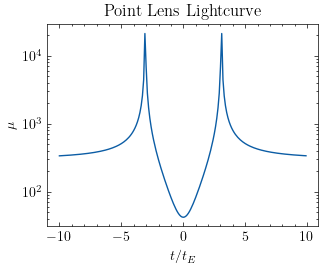

In [9]:
#calculate the magnification from the solutions found at each time t
magnifications_pl = []

for i in all_solutions_pl:
    mag_temp = []
    if len(i[0]) > 0:
        for j in i[0]:
            mag_temp.append(1/np.abs(pl_embedded_magnification_inv(j)))
    if len(i[1]) > 0:
        for j in i[1]:
            mag_temp.append(1/np.abs(pl_embedded_magnification_inv(j)))
    total_mag = np.sum(mag_temp)
    magnifications_pl.append(total_mag)

#Plot lightcurve

plt.plot(timestamps, magnifications_pl)
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.yscale('log')
plt.title(r'Point Lens Lightcurve')

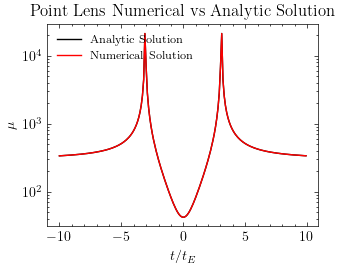

In [10]:
#Comparing lightcurve from analytic solution to that from numerical solution

plt.plot(timestamps, pl_total_mag(timestamps), color = 'black', label = 'Analytic Solution')
plt.plot(timestamps, magnifications_pl, color = 'red', label = 'Numerical Solution')
plt.yscale('log')
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.title(r'Point Lens Numerical vs Analytic Solution')
plt.legend(loc='upper left', fontsize='smaller')

## Boson star embedded in macro lens

In [11]:
#interpolating the boson star mass profile:
def m(mtau,tau_m=1.0): #mtau Pandas DataFrame, tau_m consant
    mtau_cop = mtau.copy()
    mtau_cop.iloc[:,0] = tau_m * mtau_cop.iloc[:,0]
    mtau_interp = interp1d(mtau_cop.iloc[:,0], mtau_cop.iloc[:,1], kind='cubic', fill_value='extrapolate')
    return mtau_interp

def m_prime(m,tau):
    return derivative(m, tau, maxiter=2, order=3)

def inverse_magnification(m,tau): #inverse magnification due to BS embedded in macro model
    return (
        ((1/mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (1/mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
        ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
        (1/mu_r - 1/mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))
    )

In [ ]:

def lens_eqn(tau, t, m_tau): # Embedded boson star lens equation for image position(s) tau at time t
    # images are solutions to this equation equalling 0
    return (tau / mu_r) - (m_tau(tau) / tau) - impact_par(t)


In [ ]:

tau_values_pos = np.linspace(0.001, 100, 10000)
tau_values_neg = np.linspace(-100, -0.001, 10000)

# Function to solve the BS lens equation for a given tau_m over a range of timestamps
def lens_eqn_solver(tau_m, timestamps_=timestamps, tau_values_pos_=tau_values_pos, tau_values_neg_=tau_values_neg):
    all_solutions = []
    m_tau = m(data, tau_m)

    for t in timestamps_: 

        lens_eqn_vals_pos = [lens_eqn(tau, t, m_tau) for tau in tau_values_pos_]
        lens_eqn_vals_neg = [lens_eqn(tau, t, m_tau) for tau in tau_values_neg_]
        roots_pos = []
        roots_neg = []

        for i in range(len(tau_values_pos_) - 1):
            if lens_eqn_vals_pos[i] * lens_eqn_vals_pos[i+1] < 0:
                a, b = tau_values_pos_[i], tau_values_pos_[i+1]
                sol = root_scalar(lens_eqn, args=(t,m_tau), bracket=[a, b], method='brentq')
                if sol.converged:
                    roots_pos.append(sol.root)
                
        for i in range(len(tau_values_neg_) - 1):
            if lens_eqn_vals_neg[i] * lens_eqn_vals_neg[i+1] < 0:
                a, b = tau_values_neg_[i], tau_values_neg_[i+1]
                sol = root_scalar(lens_eqn, args=(t,m_tau), bracket=[a, b], method='brentq')
                if sol.converged:
                    roots_neg.append(sol.root)

        all_solutions.append((roots_pos, roots_neg)) 

    return all_solutions 


In [ ]:
# Function to calculate the lightcurve for the BS with given tau_m
def boson_star_lightcurve(tau_m):
    m_tau = m(data, tau_m)
    all_solutions = lens_eqn_solver(tau_m)
    magnifications = []

    for i in all_solutions:
        m_tau = m(data, tau_m)
        magn_temp = []
        if len(i[0]) > 0:
            for j in i[0]:
                magn_temp.append(1/np.abs(inverse_magnification(m_tau,j)))
        if len(i[1]) > 0:
            for j in i[1]:
                magn_temp.append(1/np.abs(inverse_magnification(m_tau,j)))
        total_magn = np.sum(magn_temp)
        magnifications.append(total_magn)
    
    return magnifications 

magnifications_tm_10 = boson_star_lightcurve(10) 
magnifications_tm_20 = boson_star_lightcurve(20)


Text(0.5, 1.0, 'Lightcurve Comparison')

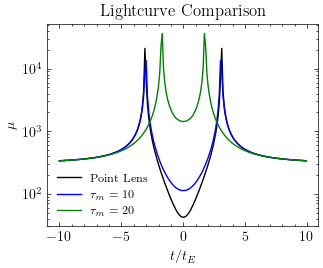

In [20]:
#compare lightcurve from boson star to that from point lens
plt.plot(timestamps, magnifications_pl, color = 'black', label = 'Point Lens')
# plt.plot(timestamps, magnifications_tm_30, color = 'red', label=r'$\tau_m = 30$')
plt.plot(timestamps, magnifications_tm_10, color = 'blue', label=r'$\tau_m = 10$')
plt.plot(timestamps, magnifications_tm_20, color = 'green', label=r'$\tau_m = 20$')
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.legend(loc='lower left', fontsize ='small')
plt.yscale('log')
plt.title(r'Lightcurve Comparison')
# plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/lightcurv_comparison.png', dpi=300, format='png')


## Fitting a PBH lightcurve to boson star lightcurve datapoints with RMSE reduction

### Searching over a grid of $t_{\rm E}$/$u_{\rm min}$ values:

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
u_min_values = np.linspace(0, 10, num = 1000)
t_E_values = np.linspace(1, 1000, num= 1000)

best_rmse = np.inf
best_u_min = None
best_t_E = None

rmse_grid = np.zeros((len(u_min_values), len(t_E_values)))

for i, u_min_ in enumerate(u_min_values):
    for j, t_E_ in enumerate(t_E_values):
        mags_pred = pl_total_mag(timestamps, u_min_, t_E_)
        rmse = np.sqrt(mean_squared_error(magnifications_tm_20, mags_pred))
        rmse_grid[i, j] = rmse
        if rmse < best_rmse:
            best_rmse = rmse
            best_u_min = u_min_
            best_t_E = t_E_

print(f"Best fit parameters from grid search: u_min = {best_u_min}, t_E = {best_t_E}")
print(f"Minimum RMSE from grid search: {best_rmse}")

Best fit parameters from grid search: u_min = 2.7327327327327327, t_E = 1.0
Minimum RMSE from grid search: 1227.9721415408235


Text(0.5, 1.0, 'Lightcurve Comparison with Best Fit Parameters ($t_{\\rm E}$=1, $u_{\\rm min}$=2.73)')

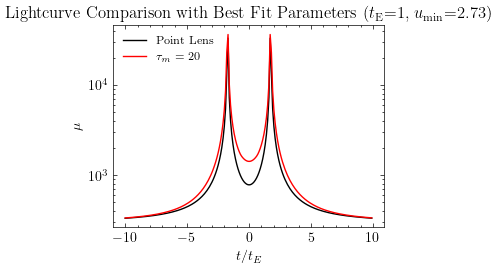

In [24]:
plt.plot(timestamps, pl_total_mag(timestamps,u_min=best_u_min,t_E=best_t_E), color = 'black', label = 'Point Lens')
plt.yscale('log')
plt.plot(timestamps, magnifications_tm_20, color = 'red', label = r'$\tau_m = 20$')
plt.legend(loc='upper left', fontsize='smaller')
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.title(r'Lightcurve Comparison with Best Fit Parameters ($t_{\rm E}$=1, $u_{\rm min}$='+ f'{best_u_min:.2f})')
# plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/lightcurve_comparison_best_fit_taum_10.png', dpi=300, format='png')